In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# 加载数据
emails = pd.read_csv('./data/Emails.csv', usecols=[3, 4])

# 读取别名和对应的Id，保存到dict中
file = pd.read_csv('./data/Aliases.csv')
aliases = {}
for index, row in file.iterrows():
    aliases[row['Alias']] = row['Id']

# 读取Id和对应的人名，保存到dict中
file = pd.read_csv('./data/Persons.csv')
persons = {}
for index, row in file.iterrows():
    persons[row['Id']] = row['Name']

In [3]:
# 处理别名
def unify_name(name):
    name = str(name).lower() # 全部小写
    name = name.replace(',', '').split('@')[0] # 去掉,和@后内容
    if name in aliases.keys(): # 转化别名
        return persons[aliases[name]]
    return name
    
emails['MetadataFrom'] = emails['MetadataFrom'].apply(unify_name)
emails['MetadataTo'] = emails['MetadataTo'].apply(unify_name)

In [4]:
# 画网络图
def show_graph(graph):
    positions = nx.spring_layout(graph) # 使用Spring Layout布局，类似中心放射状
    nodesize = [x['pagerank']*2000 for v, x in graph.nodes(data=True)] # 设置网络图中的节点大小，大小与pagerank值相关，因为pagerank值很小所以需要*20000
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)] # 设置网络中的边长度
    nx.draw_networkx_nodes(graph, positions, node_size=nodesize, alpha=0.4) # 绘制节点
    nx.draw_networkx_edges(graph, positions, edge_size=edgesize, alpha=0.2) # 绘制边
    nx.draw_networkx_labels(graph, positions, font_size=10) # 绘制节点的label
    plt.show()

In [5]:
# 设置边的权重等于发邮件的次数
edges_weights_temp = {}
for row in zip(emails.MetadataFrom, emails.MetadataTo):
    temp = (row[0], row[1])
    if temp not in edges_weights_temp.keys():
        edges_weights_temp[temp] = 1
    else:
        edges_weights_temp[temp] = edges_weights_temp[temp] + 1
        
# 转化格式(from, to), weight => from, to, weight
edges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]

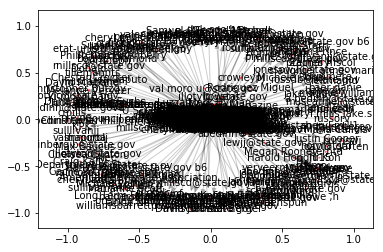

In [6]:
graph = nx.DiGraph() # 创建一个有向图
graph.add_weighted_edges_from(edges_weights) # 设置有向图中的路径及权重(from, to, weight)
pagerank = nx.pagerank(graph) # 计算每个节点（人）的PR值，并作为节点的pagerank属性
pagerank_list = {node: rank for node, rank in pagerank.items()} # 获取每个节点的pagerank数值
nx.set_node_attributes(graph, name='pagerank', values=pagerank_list) # 将pagerank数值作为节点属性
show_graph(graph) # 画网络图

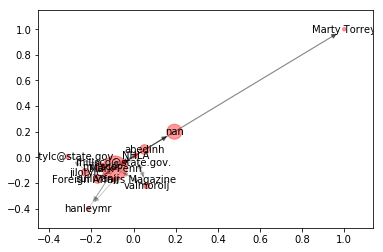

In [7]:
# 将完整的图谱进行精简
pagerank_threshold = 0.005 # 设置PR值的阈值，筛选大于阈值的重要核心节点
small_graph = graph.copy() # 复制一份计算好的网络图
for n, p_rank in graph.nodes(data=True): # 减掉PR值小于pagerank_threshold的节点
    if p_rank['pagerank'] < pagerank_threshold:
        small_graph.remove_node(n)
        
show_graph(small_graph)